<img src="./documentation/images/ibm-logo.png" alt="ibm-logo" align="center" style="width: 200px;"/>

**AI ENTERPRISE WORKFLOW CERTIFICATION**

<hr />

### Capstone Project - Exporatory Data Analysis


# Introduction

Recently at AAVAIL there has been discussion among management about different approaches to revenue generation. AAVAIL launched using a tiered, subscription-based service which showed promise, but conversations with users, especially those outside of US markets, prompted an experiment using an à la carte approach. This experiment was carried out mostly outside of the US and there are now a couple of years of data with a few thousand active users. The data are transaction-level purchases across 38 different countries and are invoiced in batches. Management has nearly decided to make the switch to the new model, but they find it difficult to predict monthly revenue. They have asked you to create a service that, at any point in time, will predict the revenue for the following month. They have also asked that the service be given the ability to project revenue for a specific country. To keep the development time reasonable you have been advised to limit your model to the ten countries with the most revenue.

You have spoken at length with the managers who will be the end users of this model and they are confident that this product will have a meaningful business impact. Currently, these managers are using their own methods to predict revenue, but they have come to feel that they are spending too much time on this and their lack of expertise in data science means their predictions are not as accurate as they would like. The management team expects to spend less time creating their own projection models, and they expect the new results to be more accurate. They have assured you that well-projected numbers will help stabilize staffing and budget projections which will have a beneficial ripple effect throughout the company.

The business metric could be a function of managers’ time saved due to automation and revenue gained through more accurate predictions, but many of the necessary factors are difficult or impossible to quantify. It is sometimes the case that the ideal business metric is impractical to directly measure or estimate. Instead, you and the management team have decided that the measure of success for this project will be the improvement in accuracy relative to the current spreadsheet-based model, which we will provide in part 3.

# Deliverables

### 1. Assimilate the business scenario and articulate testable hypothesis

The main business objectives are listed as follows:

* Build a tool which at any point in time will predict the revenue for the following month
* Have the ability to project revenue for a specific country
* Limit the model to the ten countries with the most revenue

Managers will be the end users of this model. Currently, they are using their own methods to predict revenues which is time consuming and the predictions are less accurate due to lack of data science expertise. Good projected numbers from the model will help stabilize staffing and budget projections.

Business metrics:
* time saved due to automatization
* revenue gained due to more accurate predictions compared to the current spread-sheets

**Testable Hypothesis**
Because the advanced of AI could handle more data and solve complex solutions, the new model could be more accurate than the current spreadsheets. In addition, the full automatization will reduce human intervention, making the process robust and less prone to errors.

### 2. State the ideal data to address the business opportunity and clarify the rationale for needing specific data

**Target Value**
The target value are the revenue numbers per country. These numbers could break down to daily revenues. Historical revenues data is needed to train and evaluate the model. Revenue is given as the product of price and volume.

**Feature matrix**
Historical data for invoices could be used to predict the revenues. For example data such as, country, customer, service/product, price and volume could be used to calculate the revenues and identify the most significant factors that have an impact in the revenues prediction.

### 3. Create a python script to extract relevant data from multiple data sources, automating the process of data ingestion.

**Automatize Data Ingestion**

In [41]:
%%writefile data_ingestion.py
#!/usr/bin/env python

import os
import re
import time
import numpy as np
import pandas as pd
from datetime import datetime

## Project directories
PROJECT_ROOT_DIR = "."
DATA_DIR = os.path.join("data")
DEV = True
   
def _ingest_data(dev=DEV, verbose=True):
    """
    load, join and clean json invoice data
    """
    
    if dev:
        data_dir = os.path.join(PROJECT_ROOT_DIR,DATA_DIR,"train")
    else:
        data_dir = os.path.join(PROJECT_ROOT_DIR,DATA_DIR,"production")
    
    ## Check the data directory
    if not os.path.exists(data_dir):
        raise Exception("specified data dir does not exist")
    
    if not len(os.listdir(data_dir))>=1:
        raise Exception("specified data dir does not contain any files")
        
    ## create a list with all json files in the data directory
    if verbose:
        print("...reading from json files")
    json_files = [os.path.join(data_dir,f) for f in os.listdir(data_dir) if re.search("\.json",f)]
    
    ## read json file from the data directory
    total = len(json_files)
    if verbose:
        print("...{} json files in the '{}' directory".format(total, data_dir))
    aavail_data = {}
    for iteration,json_file in enumerate(json_files):
        if verbose:
            end = "" if (iteration+1) < total else "\n"
            print("\r...reading file: {}/{}".format(iteration+1,total), end=end)
        key = os.path.split(json_file)[-1]
        df = pd.read_json(json_file)
        aavail_data[key] = df
    
    ## default columns names
    column_names = ['country', 'customer_id', 'day', 'invoice', 'month', 'price', 'stream_id', 'times_viewed', 'year']
    
    ## rename columns to uniformly named features
    for invoice, df in aavail_data.items():
        if "StreamID" in df.columns.values:
            df.rename(columns={'StreamID':'stream_id'},inplace=True)
        if "TimesViewed" in df.columns.values:
            df.rename(columns={'TimesViewed':'times_viewed'},inplace=True)
        if 'total_price' in df.columns.values:
            df.rename(columns={'total_price':'price'},inplace=True)
        if set(df.columns.values) != set(column_names):
            raise Exception("column names for {} could not be matched to correct columns".format(invoice))
    
    ## concatenate the data to one dataframe
    df = pd.concat(aavail_data, ignore_index=True)
    print("...concatenated to dataset of {} rows and {} columns".format(df.shape[0], df.shape[1]))
    
    ## Extract date from year, month and day
    df["invoice_date"] = pd.to_datetime(df[["year","month","day"]])

    ## invoice IDs should not contain any letters
    df["invoice_id"] = df["invoice"].str.replace(pat="\D+", repl="", regex=True).values.astype(np.int)
    df.drop(["invoice"], axis=1, inplace=True)
    
    return df

def _convert_to_ts(df, country=None):
    """
    convert the original clean dataframe to a time series
    by aggregating over each day for the given country
    """
    
    ## define the columns to group
    if country:
        cols = ["invoice_date", "country"]
    else:
        cols = ["invoice_date"]
        
    ## group the data    
    grouped = df.groupby(cols)
    
    ## count the purchases
    df_count = grouped[["price"]].count()
    df_count.rename(columns={'price':'purchases'},inplace=True)
    
    ## apply aggregation functions
    df_aggr = grouped.agg({"invoice_id":"nunique","stream_id": "nunique","times_viewed":"sum","price":"sum"})
    df_aggr.rename(columns={"invoice_id":"unique_invoices","stream_id":"unique_streams","times_viewed":"total_views","price":"revenue"}, inplace=True)
    
    ## merge the counts and the results from aggregation
    df_final = df_count.merge(df_aggr, left_index=True, right_index=True).reset_index()
    
    if country:
        mask = df_final.country == country
        return df_final[mask].drop("country", axis=1).set_index("invoice_date")
    else:
        return df_final.set_index("invoice_date")
    
def ingest_ts(clean=True, dev=DEV, verbose=True):
    """
    fetch timeseries data
    if the csv files exist, it reads from the file directory,
    otherwise it creates them from the original data and saves the files
    """
    
    if verbose:
        print("Ingesting Data")
    
    if dev:
        ts_dir = os.path.join(PROJECT_ROOT_DIR,DATA_DIR,"train-ts")
    else:
        ts_dir = os.path.join(PROJECT_ROOT_DIR,DATA_DIR,"production-ts")
        
    ## Check the data directory
    if not os.path.exists(ts_dir):
        os.makedirs(ts_dir)
        
    if (len(os.listdir(ts_dir)) > 0) & (clean == False):
        if verbose:
            print("...loading timeseries data from files")
        ts_files = [os.path.join(ts_dir,f) for f in os.listdir(ts_dir) if re.search("\.csv",f)]
        return {re.sub("\.csv","",os.path.split(f)[-1]):pd.read_csv(f, index_col=0) for f in ts_files}
        
    ## Load original data
    df = _ingest_data(dev=dev, verbose=verbose)
    

    ## Find the top ten countries by revenue
    top_10_countries = df.groupby("country")[["price"]].sum().sort_values(by="price",ascending=False)[:10].index.values.tolist()
    
    ## Add total to the countries
    countries = top_10_countries
    countries.append("Total")
    
    ## Convert the data to timeseries
    ts = {}
    if verbose:
        print("...converting data to timeseries")
    for country in countries:
        
        key = re.sub("\s+","_",country.lower())
        if key == "total":
            ts[key] = _convert_to_ts(df)
        else:
            ts[key] = _convert_to_ts(df, country=country)
        
        ## write file
        csv_path = os.path.join(ts_dir,"{}.csv".format(key))
        ts[key].to_csv(csv_path, index=True)
        
    return ts

def load_feature_matrix(clean=False, dev=DEV, verbose=True):
    """
    load the clean dataset after ingestion
    """
    
    ## load the dataset
    ts = ingest_ts(clean=clean, dev=dev, verbose=verbose)
    
    if verbose:
        print("Creating Feature Matrix")
    
    df = pd.concat(ts, keys=ts.keys(), names=["country"]).reset_index()

    ## check the type of the invoice_date
    if df.dtypes["invoice_date"] != "datetime64[ns]":
        df["invoice_date"] = pd.to_datetime(df["invoice_date"])
        
    return df

if __name__ == "__main__":
    
    run_start = time.time()
  
    ## ingest data
    ts = ingest_ts(dev=DEV)
    
    print("METADATA")
    for key, item in ts.items():
        print("...{} {}".format(key, item.shape))
    
    ## metadata
    m, s = divmod(time.time()-run_start,60)
    h, m = divmod(m, 60)
    print("...run time:", "%d:%02d:%02d"%(h, m, s))
    
    print("done")

Overwriting data_ingestion.py


In [1]:
%run data_ingestion.py

Ingesting Data
...reading from json files
...21 json files in the './data/train' directory
...reading file: 21/21


/mnt/c/Harish/IBM/Trainings/AI Academy/AI Workflow/CAPSTONE/git/Working/data_ingestion.py:65: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df = pd.concat(aavail_data, ignore_index=True)


...concatenated to dataset of 815011 rows and 9 columns
...converting data to timeseries
METADATA
...singapore (6, 5)
...hong_kong (9, 5)
...eire (293, 5)
...norway (19, 5)
...france (285, 5)
...total (495, 5)
...germany (359, 5)
...netherlands (133, 5)
...united_kingdom (495, 5)
...portugal (72, 5)
...spain (104, 5)
...run time: 0:00:33
done


### 4. Investigate the relationship between the relevant data, the target and the business metric.

**Automatize Data Visualization**

In [43]:
%%writefile data_visualization.py
#!/usr/bin/env python

import re
import time
import os
import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
plt.style.use('seaborn')

## import functions to load the data
from data_ingestion import load_feature_matrix
from data_ingestion import DEV

SMALL_SIZE = 12
MEDIUM_SIZE = 14
LARGE_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title


IMAGE_DIR = os.path.join(".","images")

def save_fig(fig_id, tight_layout=True, image_path=IMAGE_DIR):
    """
    save the image as png file in the image directory
    """
    
    ## Check the data directory
    if not os.path.exists(image_path):
        os.makedirs(image_path)
    
    path = os.path.join(image_path, fig_id + ".png")
    print("...saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

def create_plots(df):
    """
    create plots for data visualization
    """
    print("Creating Plots")
    
    ## Analyze Total revenues over time
    fig = plt.figure(figsize=(8,6))
    ax1 = fig.add_subplot(111)
    table = df[df.country=="total"].set_index("invoice_date")[["revenue"]].resample("MS").sum()
    table.plot(ax=ax1)
    ax1.set_xlabel("months")
    ax1.set_ylabel("revenues")
    ax1.title.set_text("Monthly Revenue")
    save_fig("monthly_revenues")
    
    fig = plt.figure(figsize=(8,6))
    ax1 = fig.add_subplot(111)
    df["year"] = df.invoice_date.dt.year
    table = df[df.country=="total"].set_index("invoice_date")[["revenue"]].resample("AS").sum()
    table.plot(kind='bar', stacked=False, ax=ax1, rot=0)
    ax1.set_xlabel("year")
    ax1.set_ylabel("revenue")
    ax1.title.set_text("Total revenue per Year")
    save_fig("yearly_revenues")
    
    ## Analyze revenues per country
    fig = plt.figure(figsize=(8,6))
    ax1 = fig.add_subplot(111)
    table = pd.pivot_table(df[df.country!="total"], index = ['country'], columns=["year"],values = 'revenue', aggfunc="sum")
    table.plot(kind='bar', stacked=False, ax=ax1, rot=90)
    ax1.set_xlabel("country")
    ax1.set_ylabel("revenues")
    ax1.title.set_text("Revenues in the top 10 markets")
    save_fig("revenues_per_market")
    
    ## Analyze Revenues in UK compared to the Total
    mask = (df.country=="united_kingdom") | (df.country=="total")
    df_filter = df[mask].copy()
    df_filter.drop(["invoice_date", "year"], axis=1, inplace=True)
    
    # revenue correlation matrix
    fig = plt.figure(figsize=(8,8))
    num_features = ["purchases","unique_invoices","unique_streams","total_views","revenue"]
    corrmat = df_filter.corr()
    k = len(num_features) #number of variables for heatmap
    cols = corrmat.nlargest(k, 'revenue')['revenue'].index
    cm = np.corrcoef(df_filter[cols].values.T)
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
    save_fig("correlations")

if __name__ == "__main__":
    
    run_start = time.time()
    
    df = load_feature_matrix(dev=DEV, clean=False)
    create_plots(df)
    
    print("METADATA")
    m, s = divmod(time.time()-run_start,60)
    h, m = divmod(m, 60)
    print("...run time:", "%d:%02d:%02d"%(h, m, s))
    
    print("done")

Overwriting data_visualization.py


In [48]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 216 kB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 26.0 MB 159 kB/s eta 0:00:01     |████████████████████████████████| 25.9 MB 5.0 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
%run data_visualization.py

Ingesting Data
...loading timeseries data from files
Creating Feature Matrix
Creating Plots
...saving figure monthly_revenues
...saving figure yearly_revenues
...saving figure revenues_per_market
...saving figure correlations
METADATA
...run time: 0:00:09
done


### 5. Articulate your findings using a deliverable with visualizations.

 ### Data Ingestion

* Let's consider a data ingestion script that readily accepts the data
* We will be using the invoice datasets as a basis for this case study
* Let's start by gathering data from the sources provided

We will be working on the training data given below:

* [capstone-dataset](https://github.com/aavail/ai-workflow-capstone)

**Combine the data into a single data structure**

The two most convenient structures for this task are Pandas dataframes and NumPy arrays.

- A column for country
- A column for invoice_date
- A column for purchases
- A column for unique_invoices
- A column for unique_streams
- A column for total_views
- A column for revenue (target value)

In [5]:
from IPython.display import Image
from data_ingestion import load_feature_matrix, ingest_ts, DEV

df = load_feature_matrix(dev=DEV, clean=False)
df.head(10)

Ingesting Data
...loading timeseries data from files
Creating Feature Matrix


,country,invoice_date,purchases,unique_invoices,unique_streams,total_views,revenue
0,eire,2017-11-28,86,3,83,545,375.99
1,eire,2017-11-30,33,1,33,192,194.22
2,eire,2017-12-04,64,4,61,403,484.65
3,eire,2017-12-05,30,5,30,255,97.35
4,eire,2017-12-07,19,1,19,104,133.31
5,eire,2017-12-08,2,2,2,7,20.90
6,eire,2017-12-10,14,1,14,126,96.24
7,eire,2017-12-11,5,1,5,7,17.70
8,eire,2017-12-12,100,2,89,733,435.58
9,eire,2017-12-13,49,1,49,359,153.41


Top ten rows of the clean dataset

In [6]:
import pandas as pd
ts = ingest_ts(dev=DEV,clean=False)
pd.DataFrame.from_dict({key:item.shape[0] for key, item in ts.items()},orient="index", columns=["datasize"])

Ingesting Data
...loading timeseries data from files


,datasize
eire,293
france,285
germany,359
hong_kong,9
netherlands,133
norway,19
portugal,72
singapore,6
spain,104
total,495


The are countries with few rows. More data might be useful to accurate analyze them

### Investigative Visualization

Data visualization is the discipline of trying to understand data by placing it in a visual context so that patterns, trends and correlations that might not otherwise be detected can be exposed. The tables we just created above is difficult to navigate it can be useful to use a simple plot to summarize the data. It is possible that both a table and a plot might be needed to communicate the findings and one common practice is to include an appendix in the deliverable. 

Another related practice when it comes to EDA is that the communication of your findings, usually via deliverable, is done in a clean and polished way.

The goal here is to see what factors are influencing revenues.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2270 entries, 0 to 2269
Data columns (total 8 columns):
country            2270 non-null object
invoice_date       2270 non-null datetime64[ns]
purchases          2270 non-null int64
unique_streams     2270 non-null int64
unique_invoices    2270 non-null int64
total_views        2270 non-null int64
revenue            2270 non-null float64
year               2270 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 142.0+ KB


In [8]:
df.describe()
##df.head()

,purchases,unique_streams,unique_invoices,total_views,revenue,year
count,2270.000000,2270.000000,2270.000000,2270.000000,2270.000000,2270.000000
mean,710.518943,383.147137,37.157709,3693.143172,3409.970371,2018.312335
std,935.070557,424.707965,45.923555,4564.985058,8049.971721,0.545649
min,1.000000,1.000000,1.000000,0.000000,-45645.329000,2017.000000
25%,22.000000,22.000000,1.000000,175.000000,83.617500,2018.000000
50%,76.000000,72.000000,3.000000,677.000000,301.055000,2018.000000
75%,1329.500000,780.000000,73.000000,7032.750000,5068.520000,2019.000000
max,7756.000000,1596.000000,219.000000,29374.000000,170304.180000,2019.000000


**Analyze Total revenues**

Let's plot the total revenues over time to get a better insight into the data. This will help to understand how total revenues developed over the last years. Remember the objective is to identify the main factors that influence revenues.

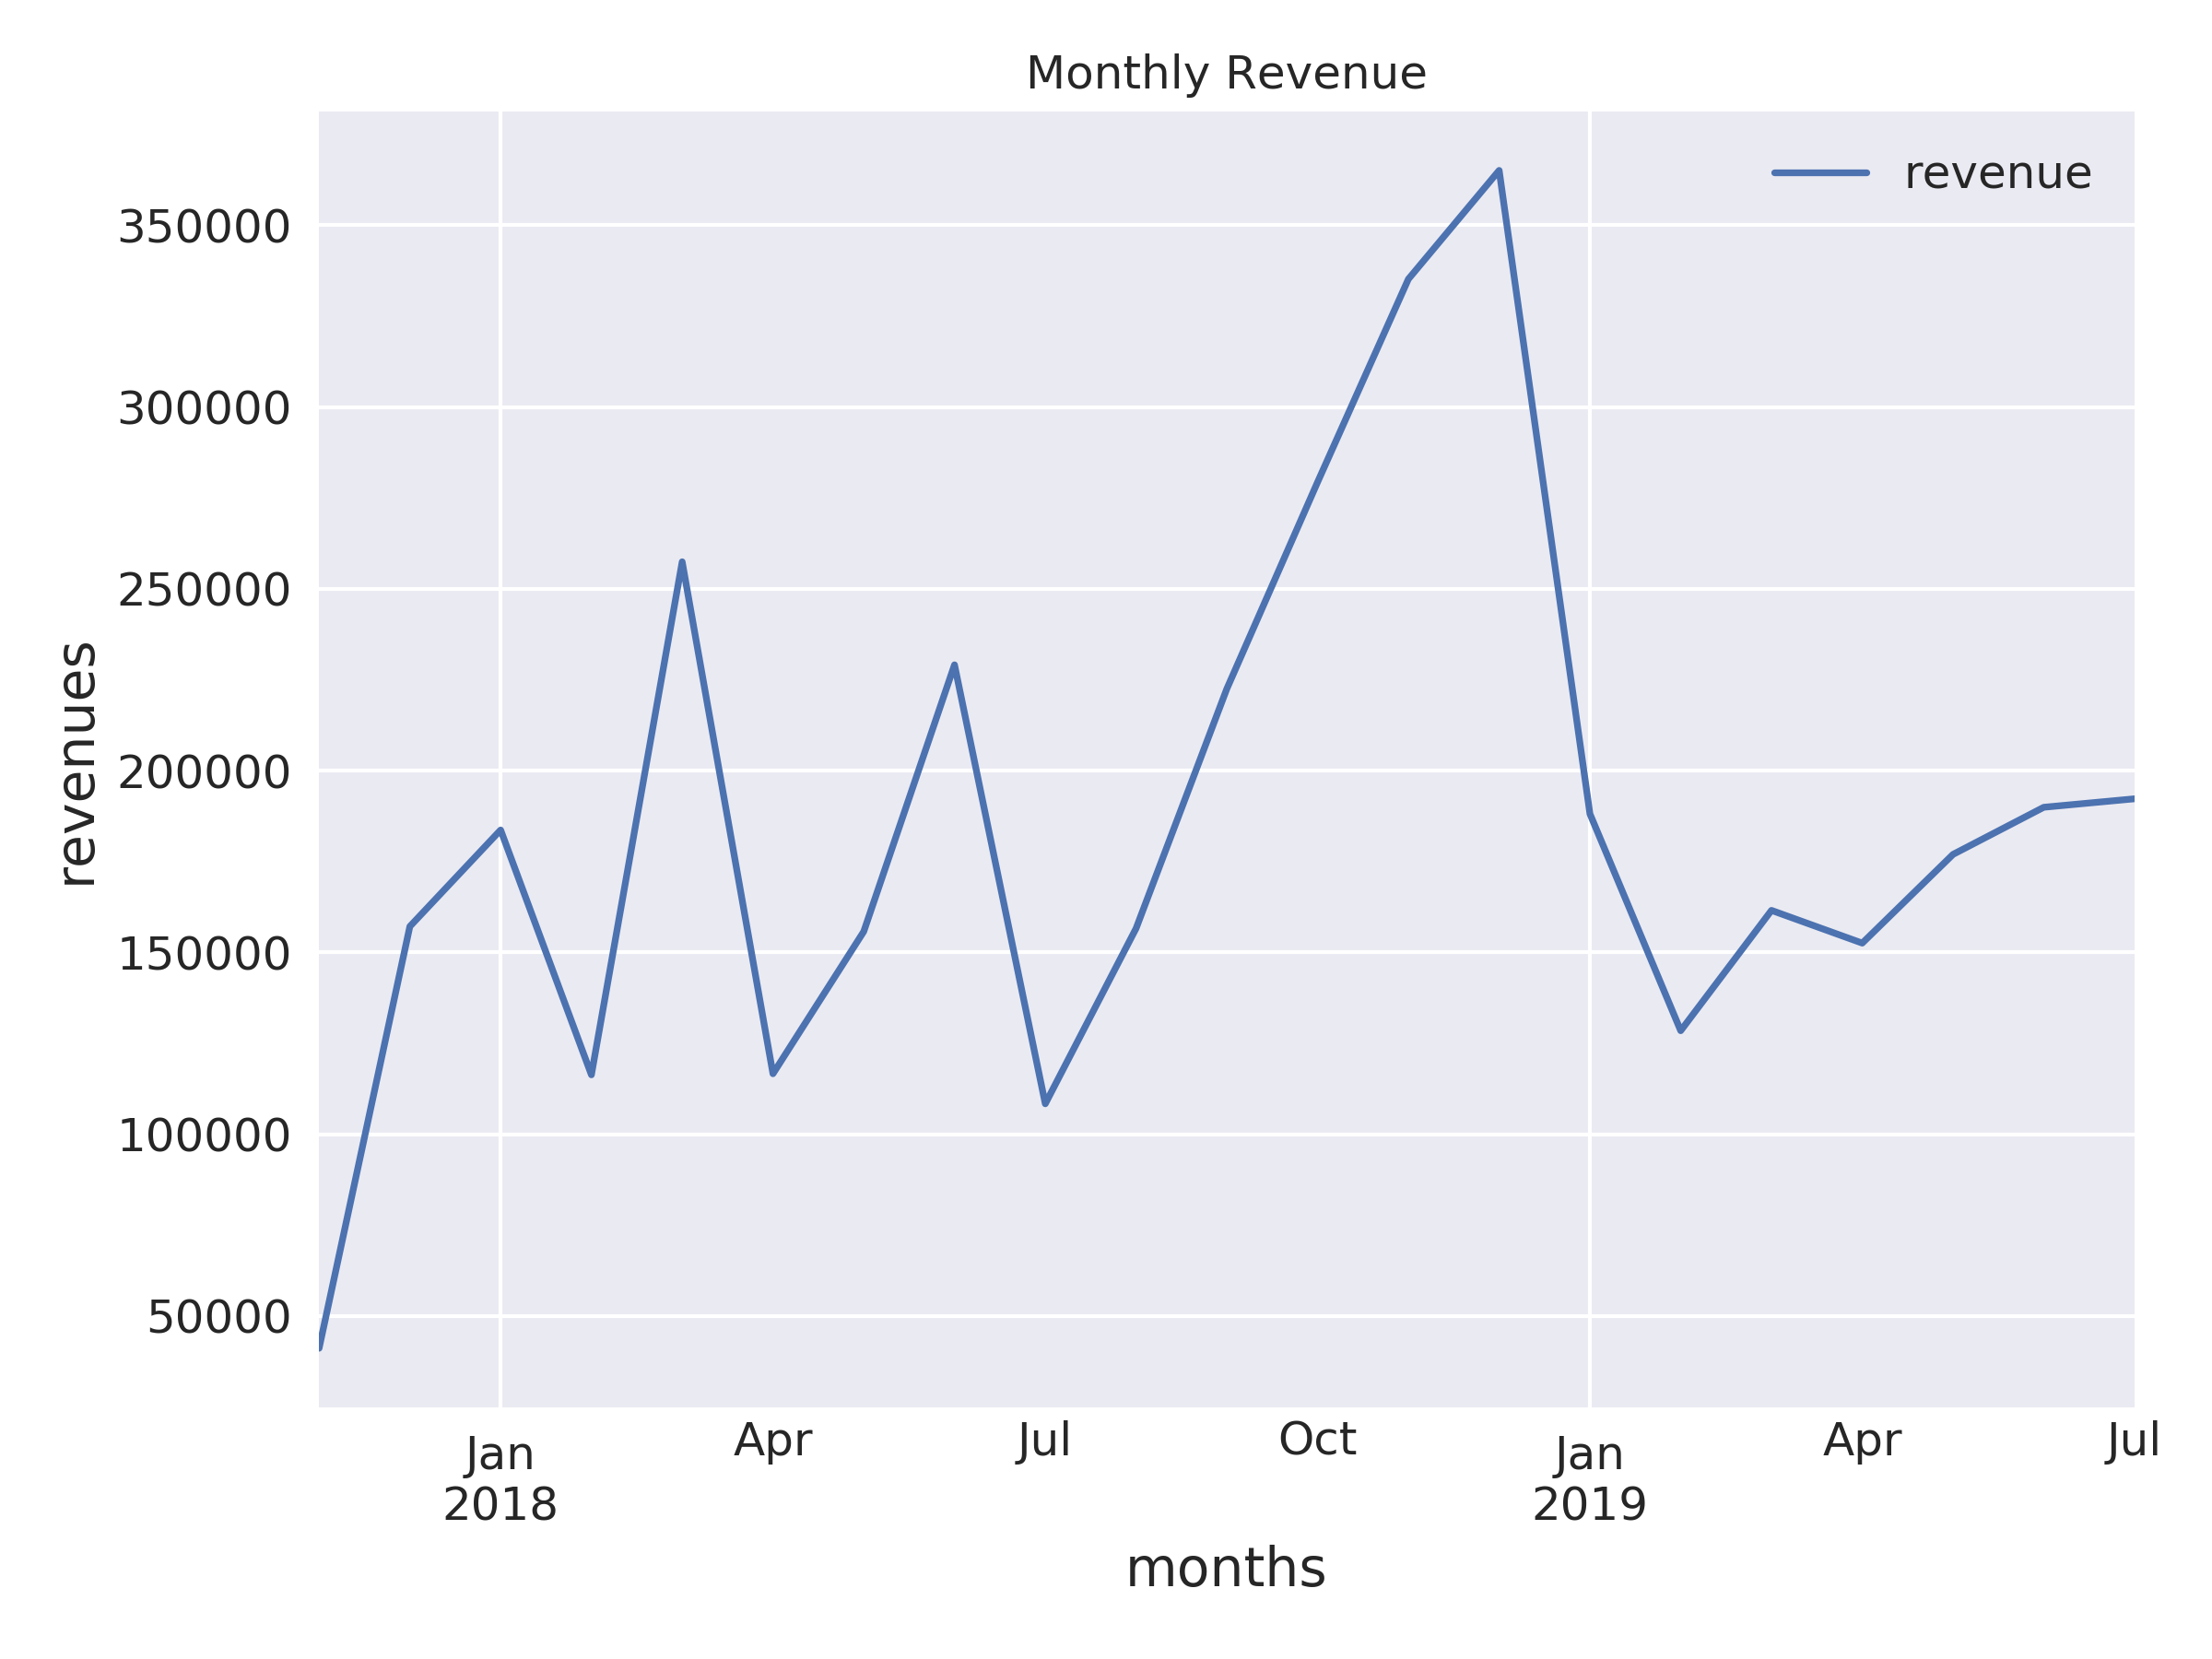

In [9]:
Image("./images/monthly_revenues.png",width=600,height=600)

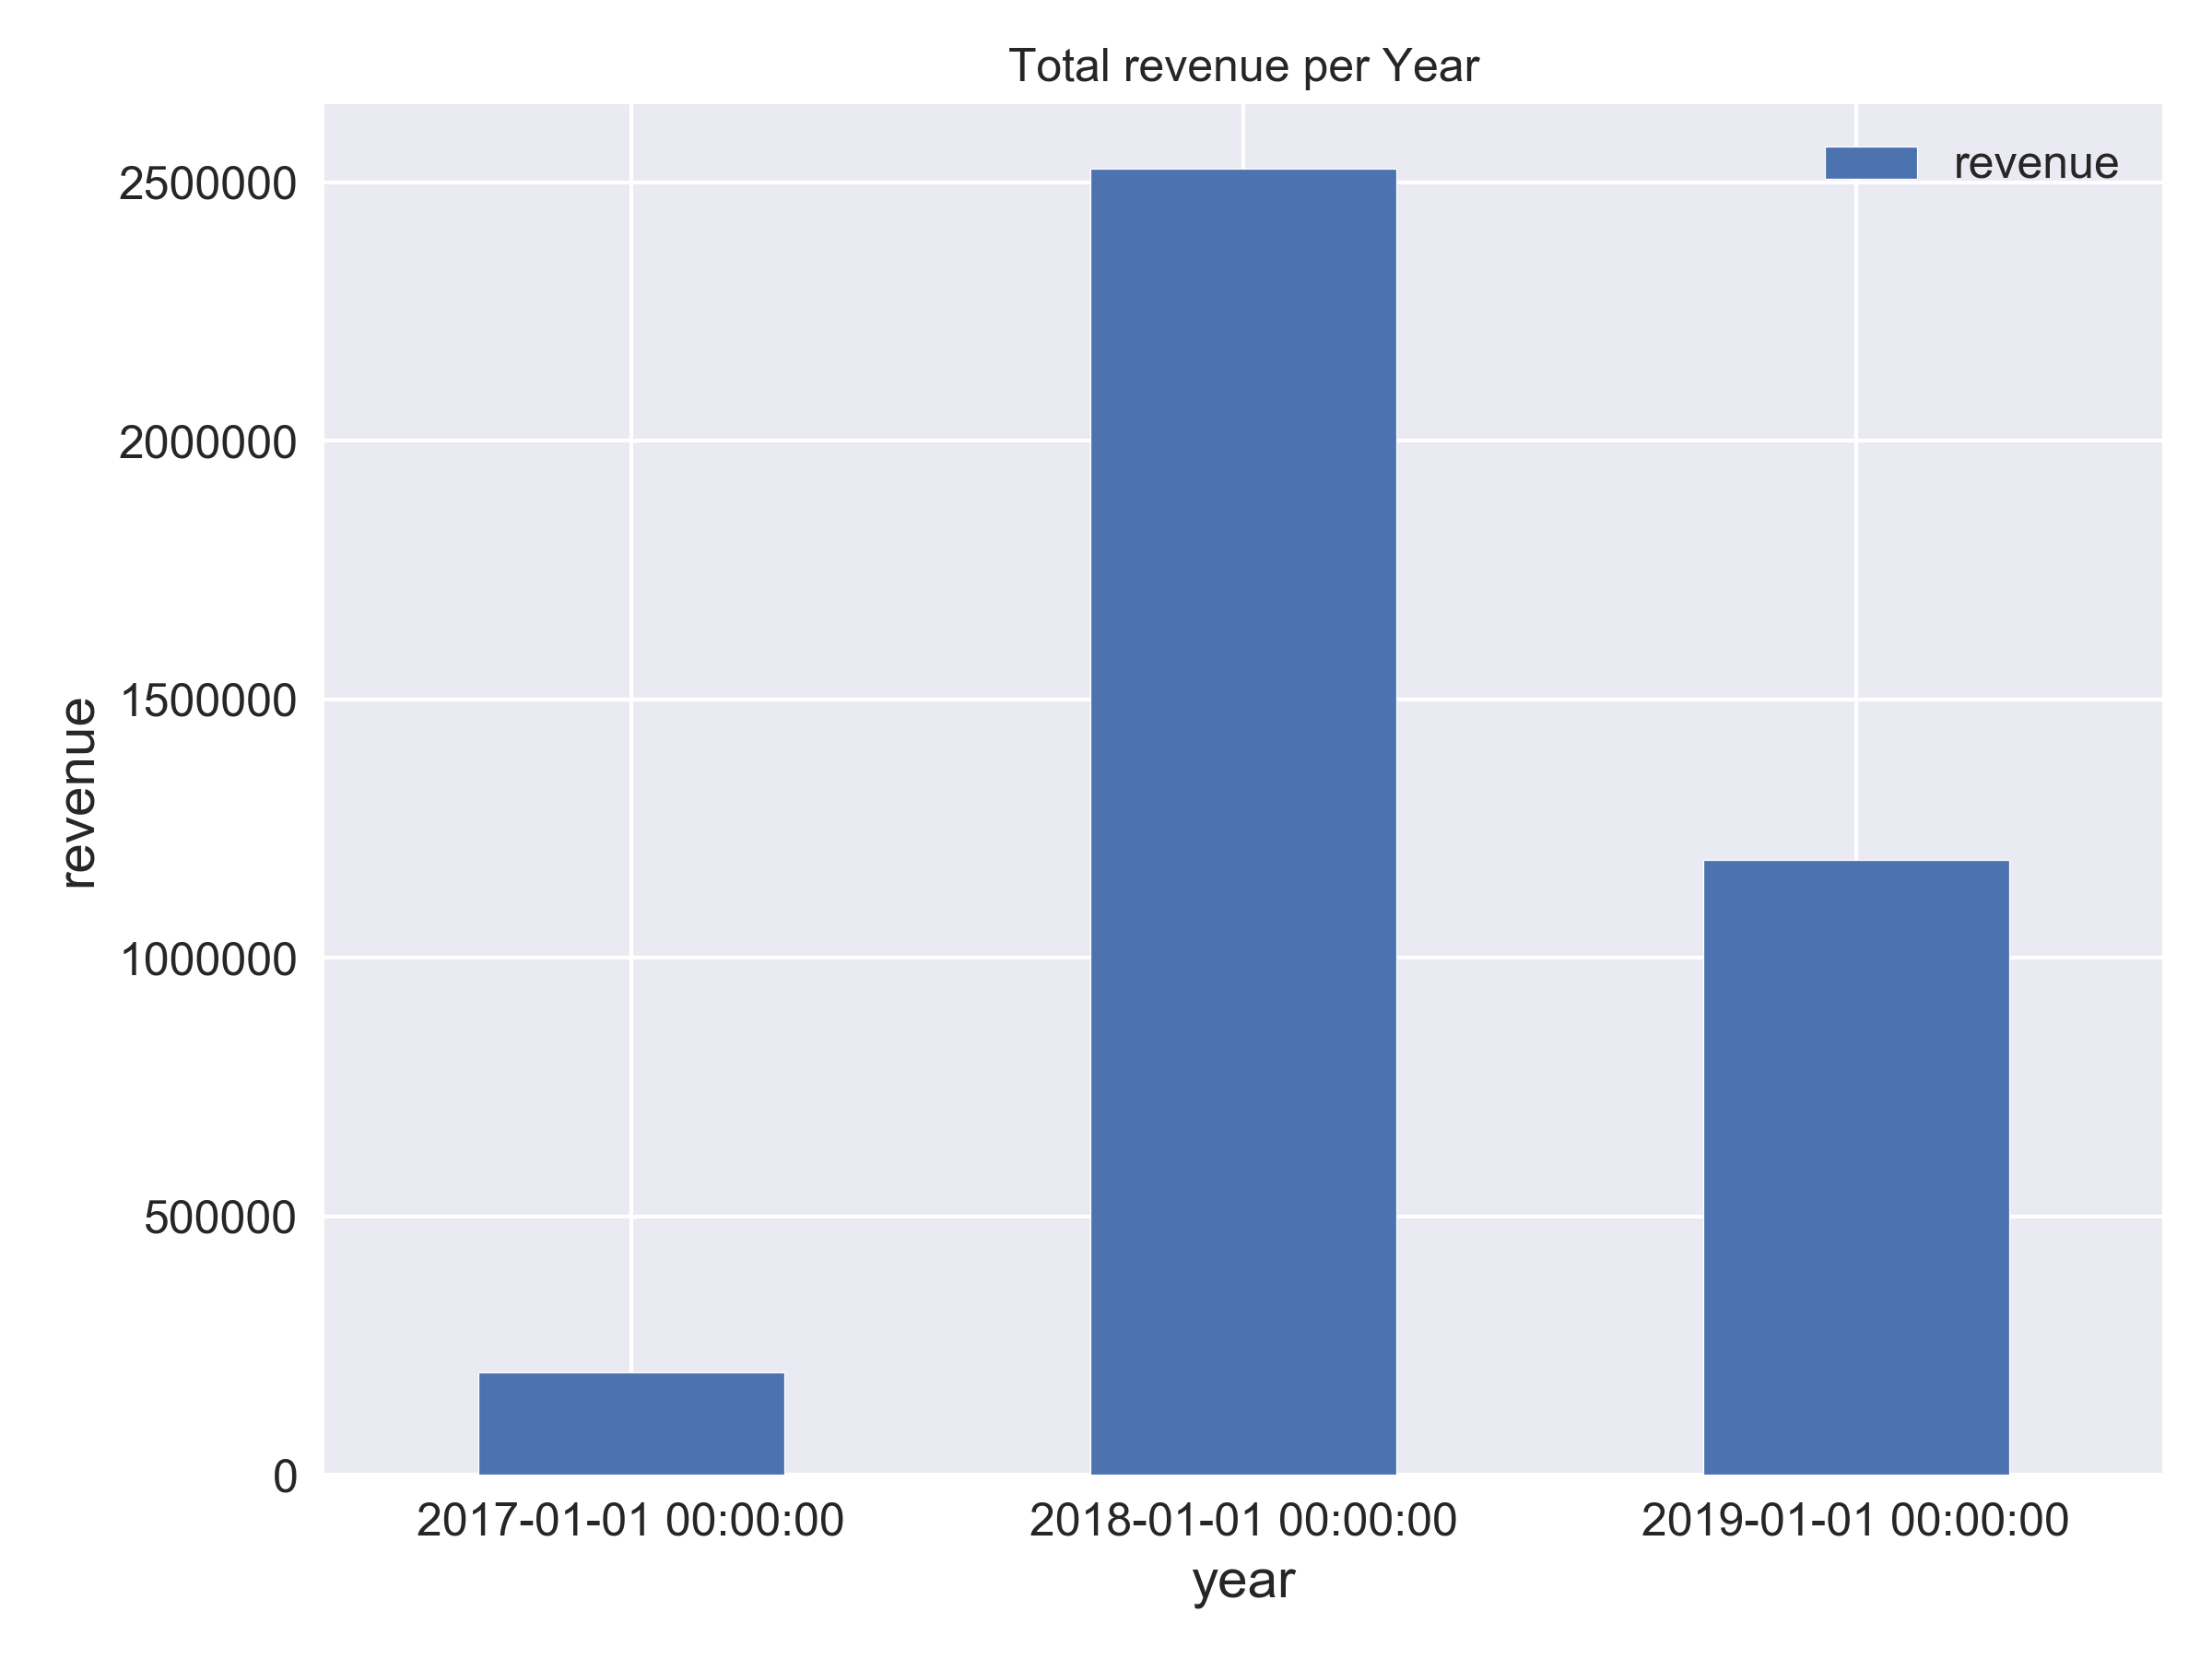

In [10]:
Image("./images/yearly_revenues.png",width=600, height=600)

 * We cannot say that the total revenues follows a seasonality pattern
 * 2018 is the year with the highest revenues (2.5 Million)
 * End of 2018 the company realized the highest revenues
 * Steep decrease in 2019. Keep in mind that 2019 is not complete

**Analyze revenues per country**

We need to understand how the revenues developed for the top countries.

In [11]:
grouped = df.groupby("country")

total = grouped["revenue"].sum().sort_values(ascending=False).round(2)
percent = (grouped["revenue"].sum() / grouped["revenue"].sum().max()).sort_values(ascending=False).round(4)
revenues = pd.concat([total, percent], axis=1, keys=["Total","Percent"])
revenues[revenues.index!="total"]

,Total,Percent
country,,
united_kingdom,3521513.50,0.8997
eire,107069.21,0.0274
germany,49271.82,0.0126
france,40565.14,0.0104
norway,38494.75,0.0098
spain,16040.99,0.0041
hong_kong,14452.57,0.0037
portugal,13528.67,0.0035
singapore,13175.92,0.0034


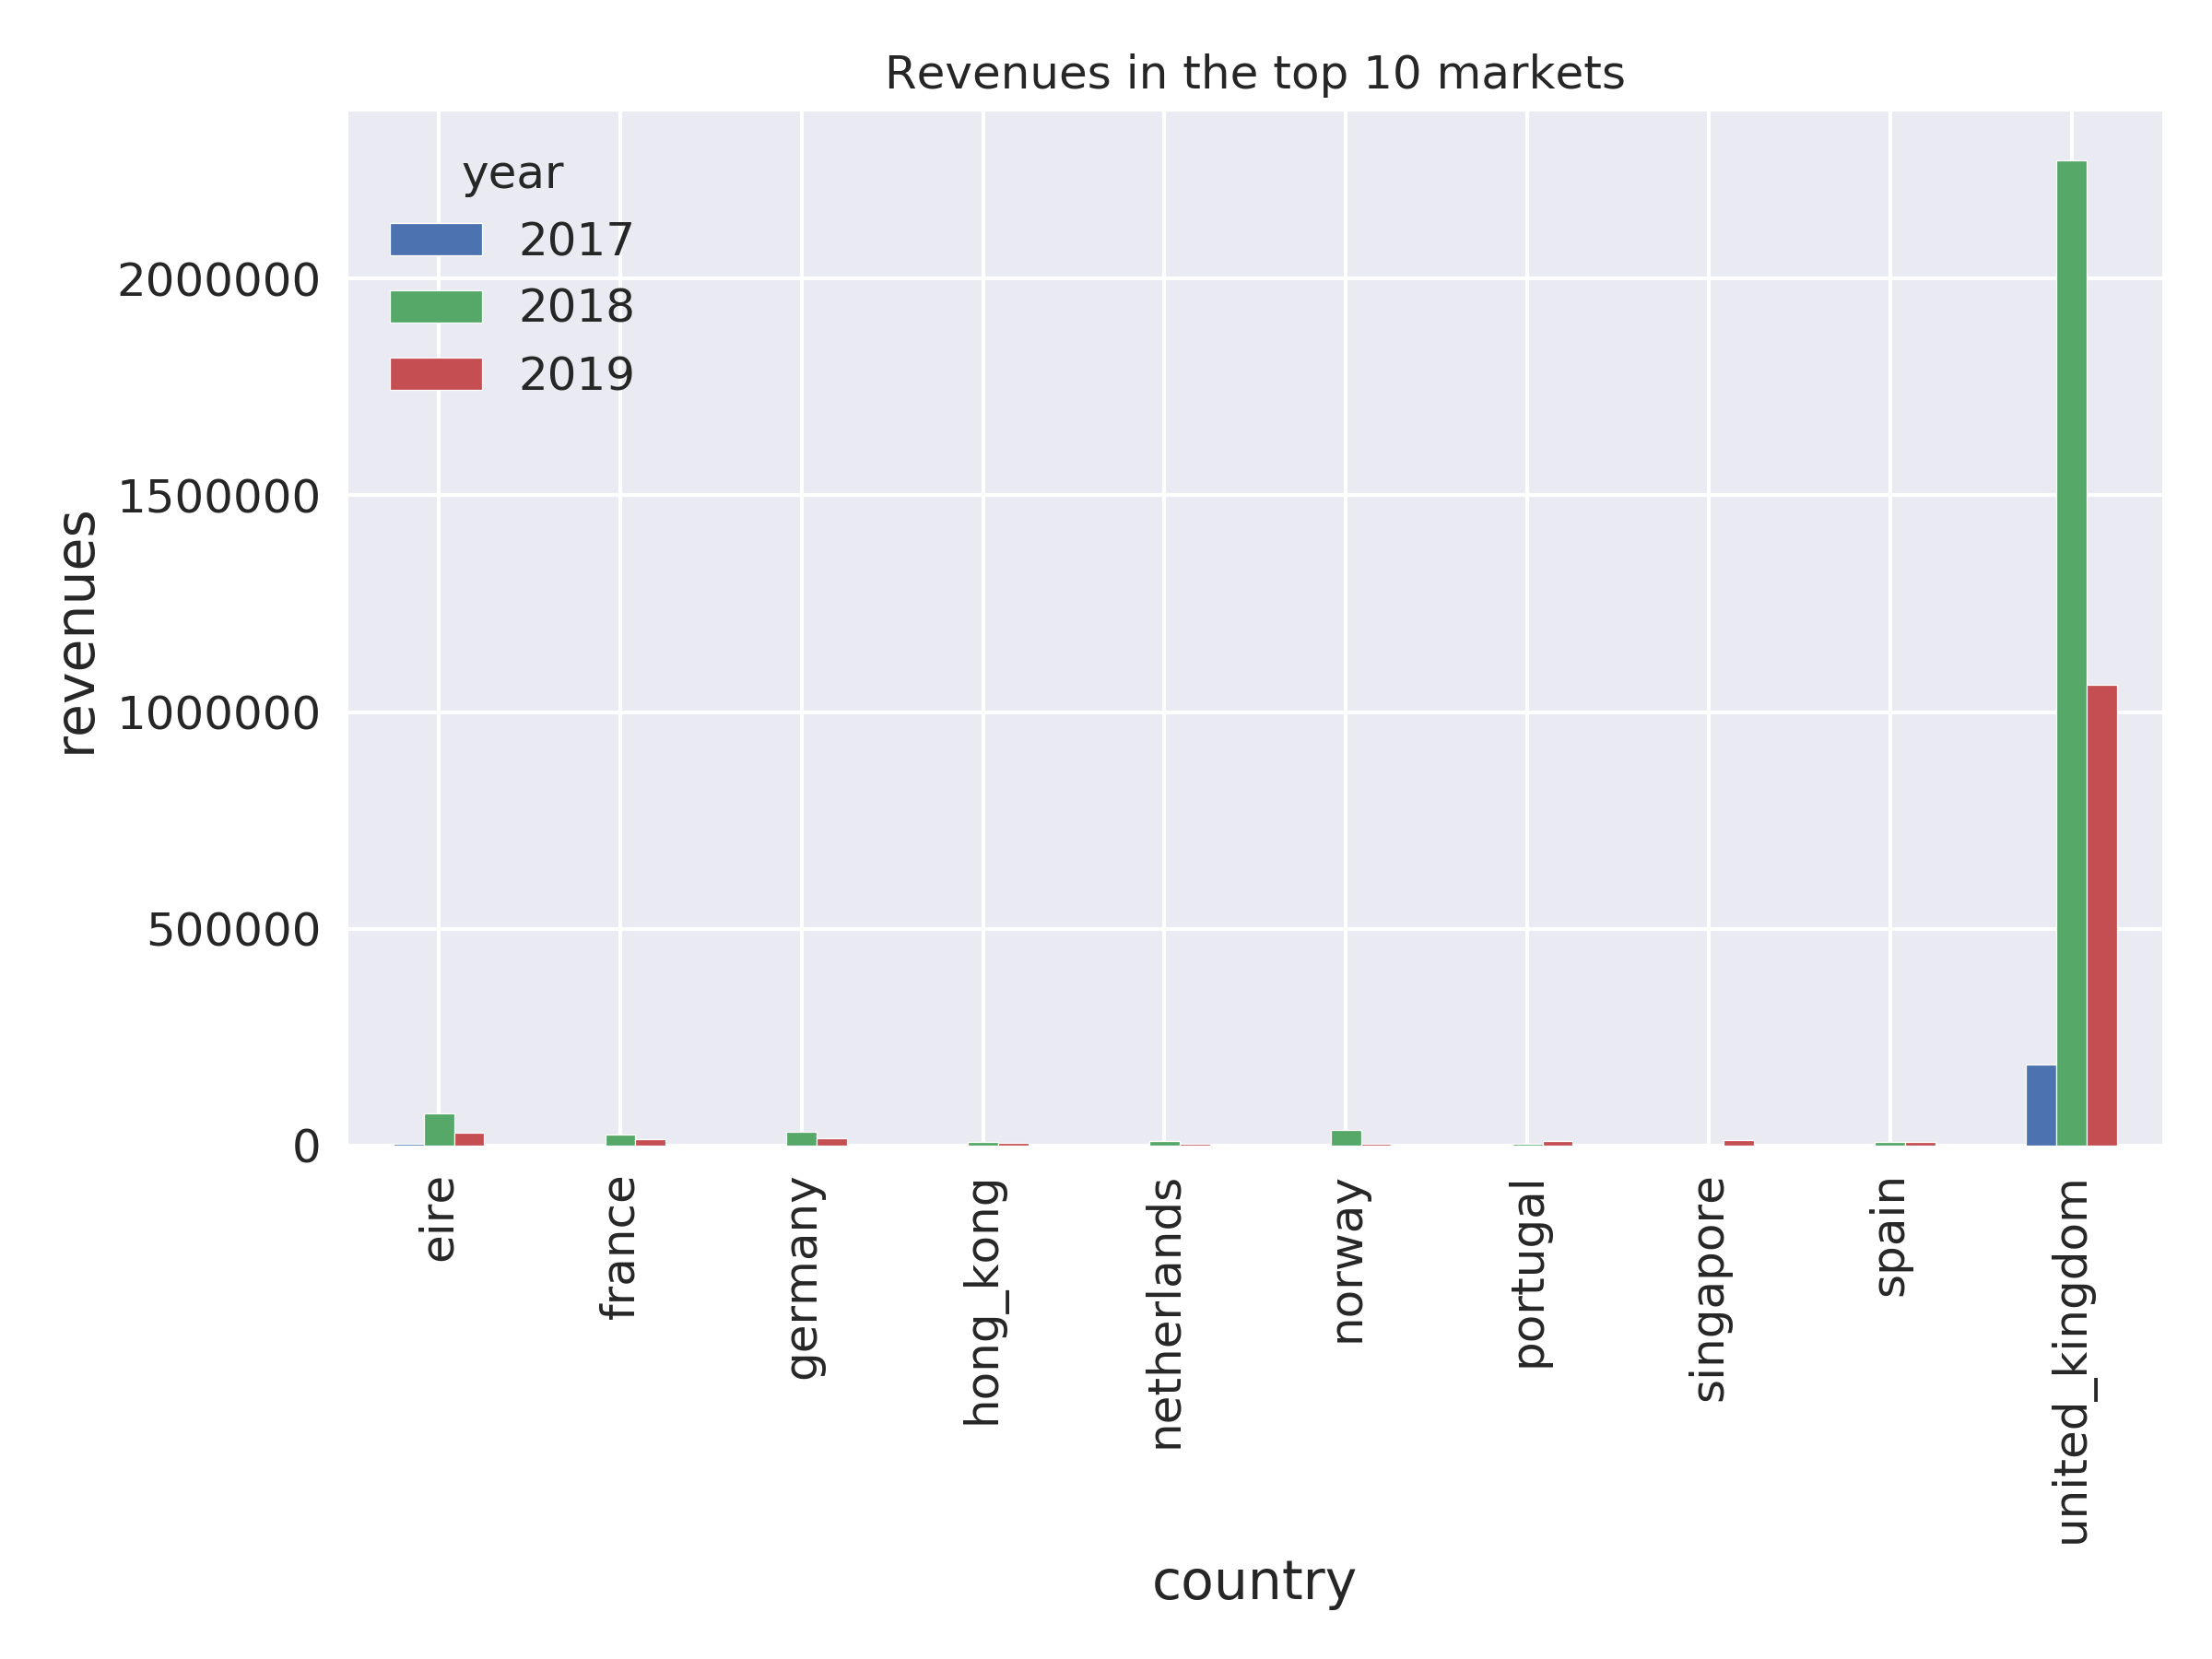

In [10]:
Image("./images/revenues_per_market.png",width=600, height=600)

* UK is the main revenue generating market with a share of almost 90%
* EIRE followed with a market share of 3%
* The other markets show significant low revenues.

**Analyze Revenues in UK compared to the Total**

We have identified differences between the countries and showed that UK is the most dominant. We need to focus more on that market and compare it with the total revenues.

In [13]:
## Focus on the UK market and compare with the total
mask = (df.country=="united_kingdom") | (df.country=="total")
df_filter = df[mask].copy()
df_filter.head()

,country,invoice_date,purchases,unique_invoices,unique_streams,total_views,revenue
1280,total,2017-11-28,3223,166,1345,15047,14450.54
1281,total,2017-11-29,3277,133,1397,14159,13411.96
1282,total,2017-11-30,3002,150,1335,15766,13290.25
1283,total,2017-12-01,2559,107,1256,12524,9687.28
1284,total,2017-12-02,402,32,287,3313,1443.26


In [14]:
df_filter.groupby(["country"]).describe()

purchases                                                  \
                   count         mean         std    min     25%     50%   
country                                                                    
total              495.0  1646.486869  825.581407  279.0  1162.0  1506.0   
united_kingdom     495.0  1517.632323  789.399009  250.0  1069.0  1367.0   

                               unique_invoices             ... total_views  \
                   75%     max           count       mean  ...         75%   
country                                                    ...               
total           1904.0  7756.0           495.0  86.153535  ...      9974.5   
united_kingdom  1739.0  7638.0           495.0  79.305051  ...      8860.5   

                        revenue                                        \
                    max   count         mean           std        min   
country                                                                 
total           29374.0   495.0  7907.469426  10972.604011 -44990.049   
united_kingdom  28444.0   495.0  7114.168697  10670.354098 -45645.329   

                                                         
                     25%       50%       75%        max  
country                                                  
total           4125.905  5971.391  8582.365  170304.18  
united_kingdom  3734.980  5369.150  7601.290  169539.62  

[2 rows x 40 columns]

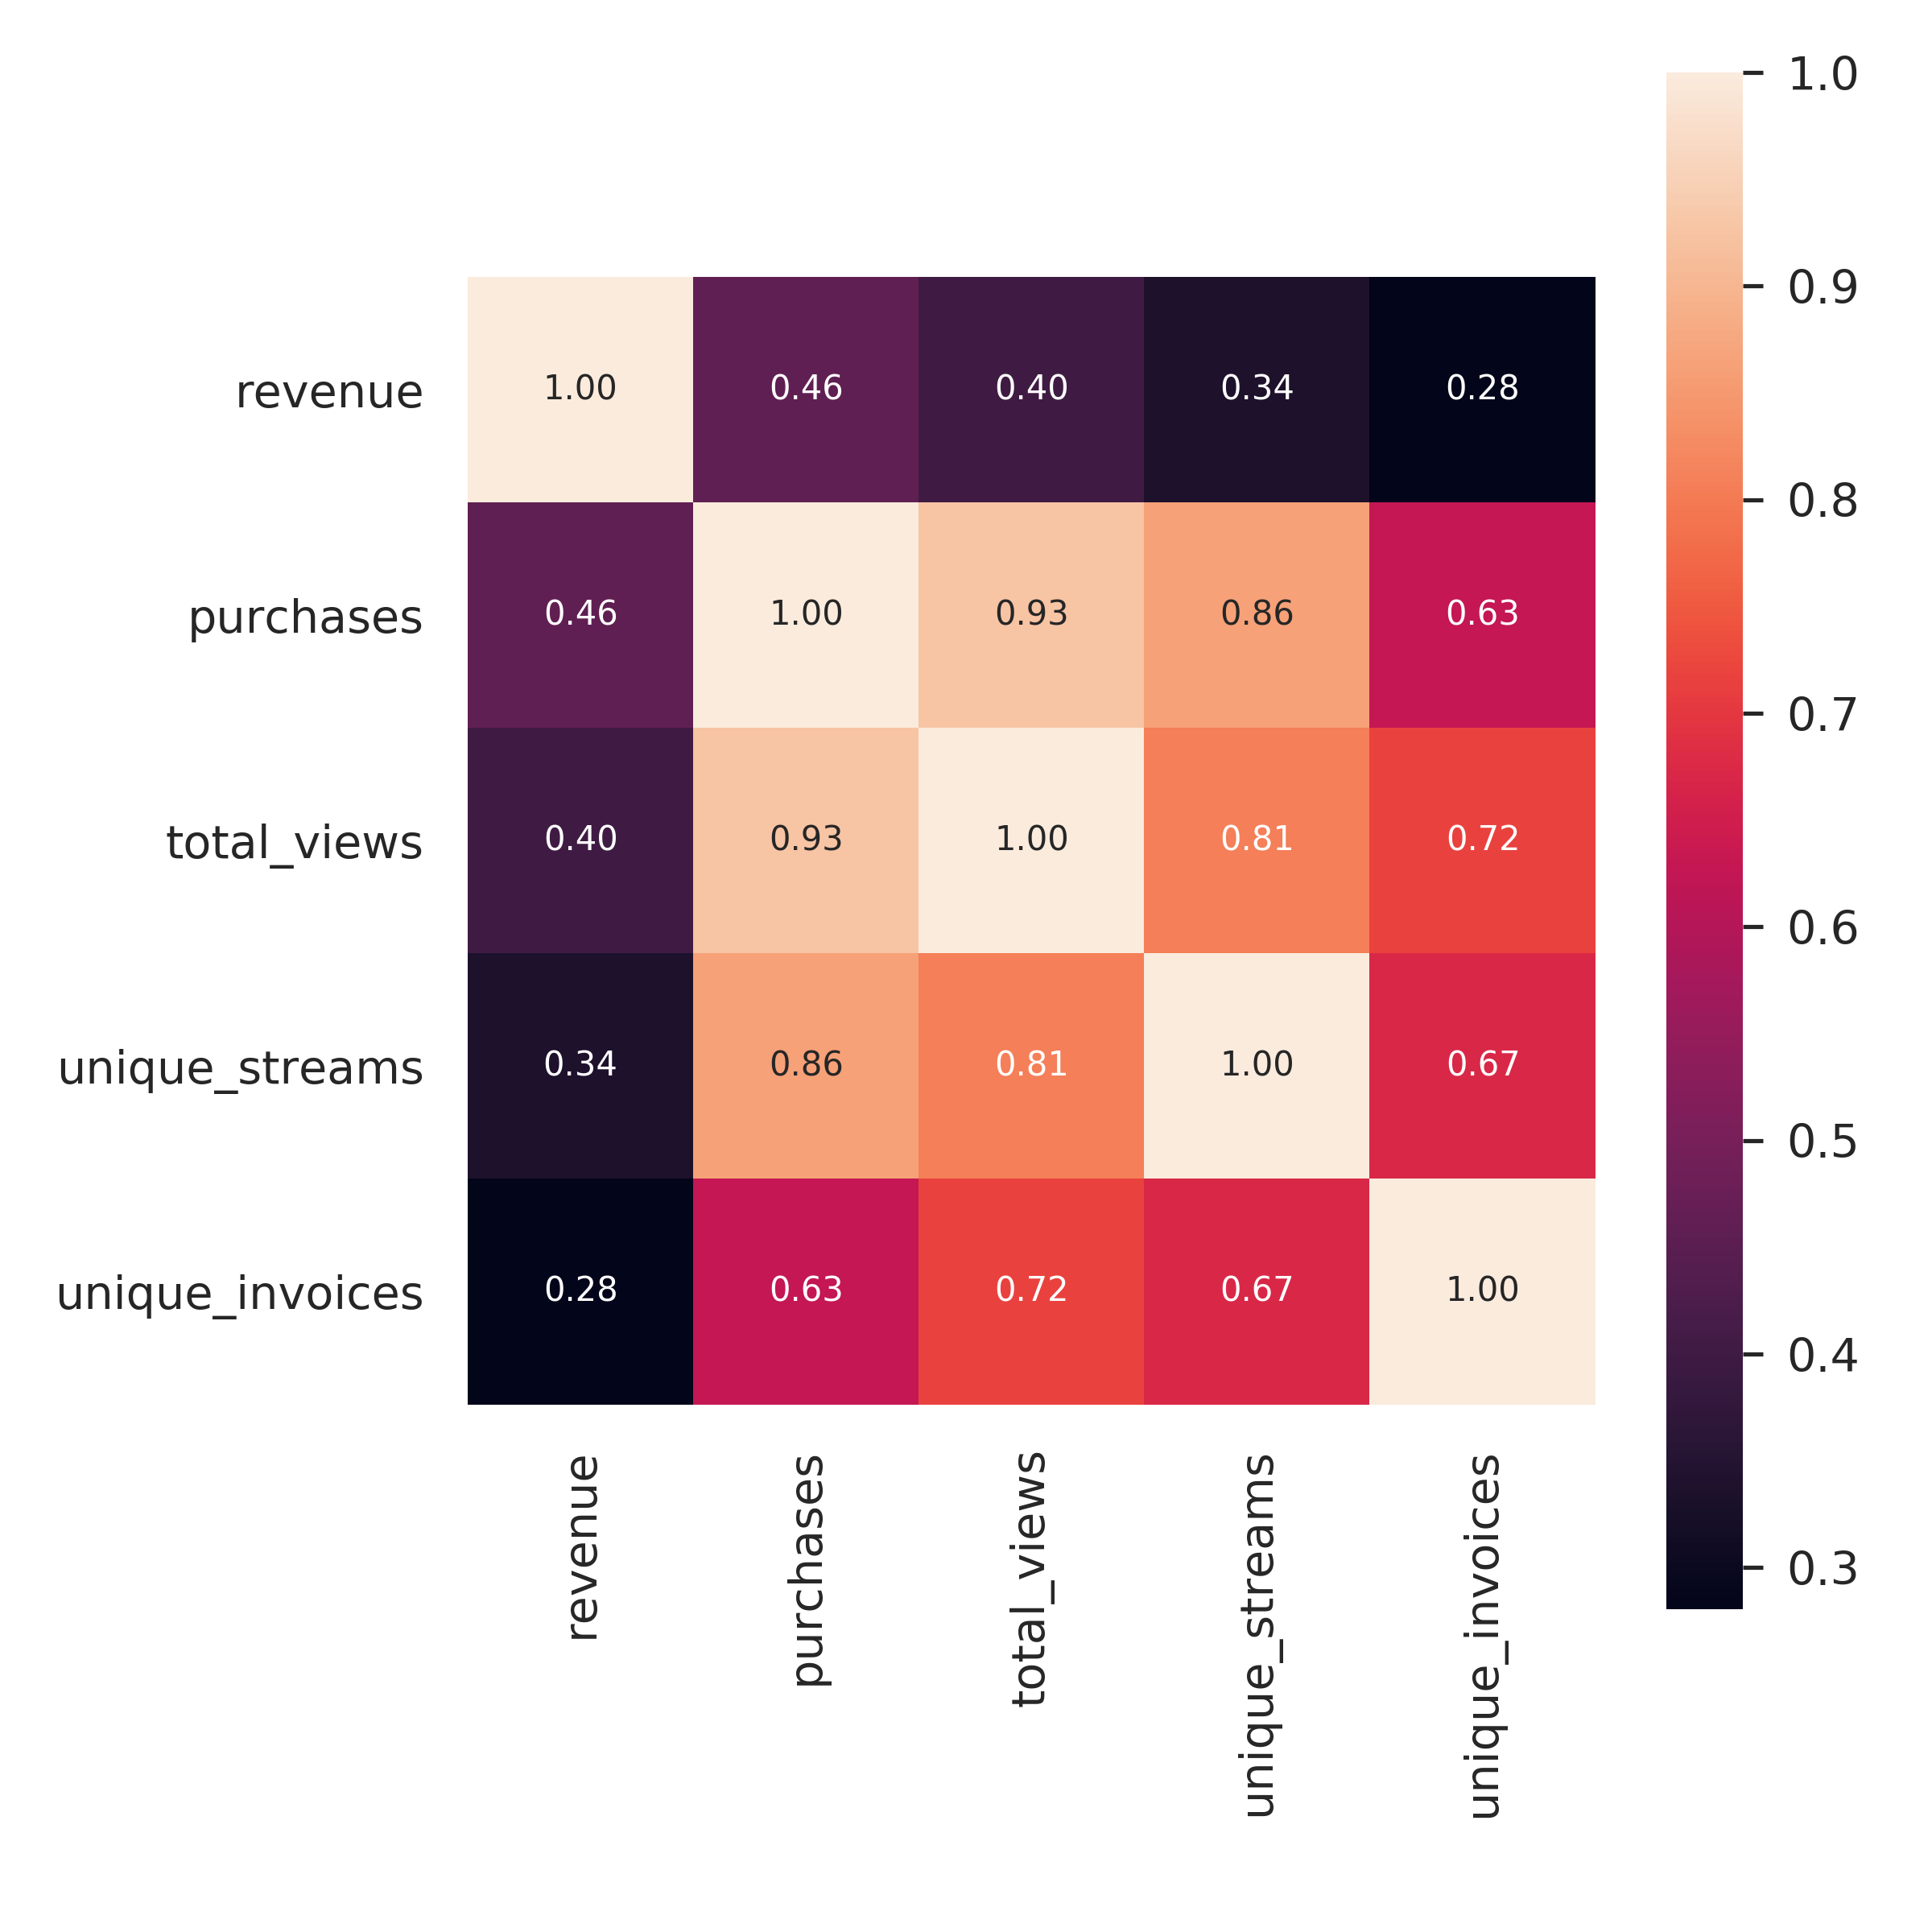

In [11]:
Image("./images/correlations.png",width=600, height=600)

### Findings from the analysis of our Features
**As we undertsand that the goal of our data analysis was to find factors that are influencing revenues**

Here are some of the findings of the data analysis:

* The historical years are not complete, only 2018
* 2018 showed the highest revenues
* There is now seasonality in the revenues
* The UK market is the dominant market
* Revenues are positively correlated with the purchases

**Next Steps**
Some of the next steps that can be performed are:

* Deep Dive Data analysis on each feature - Shall we transform the numerical features to bring them to a bell-shape distribution?
* Hypothesis testing - We can hypothesize each feature and it's importance.
* We can also calculate multiple types of aggregations for any given feature for better data explorations.

In [16]:
# to convert the jupyter to slides presentation run in the command window the following
# jupyter nbconvert --to slides --TemplateExporter.exclude_input=True part-1-data-investigation.ipynb